# Libraries and Imports


In [21]:
import os
import random
from PIL import Image
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.multiprocessing
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchviz
from torchvision.io import read_image
from torchvision import transforms
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2

# Data and Processing


In [16]:
class NumaGuardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        super(NumaGuardDataset, self).__init__()
        self.data_dir = data_dir
        self.transform = transform

        self.data = []
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            for img in os.listdir(label_dir):
                self.data.append((os.path.join(label_dir, img), int(label)))

        print(f"Loaded {len(self.data)} images")

    def __getitem__(self, index):
        img_path, label = self.data[index]
        img = read_image(img_path)

        if self.transform:
            img = self.transform(img)
        img = img.float() / 255.0

        return img, label

    def __len__(self):
        return len(self.data)

Loaded 1698 images


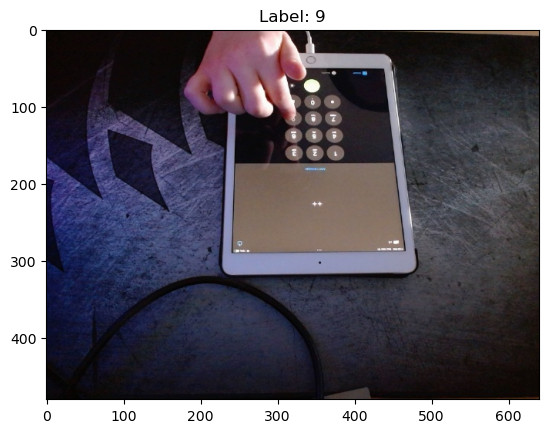

In [3]:
# check the dataset
dataset = NumaGuardDataset("data/images")
img, label = dataset[random.randint(0, len(dataset))]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.show()
dataset = None

# Model


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 2, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(16384, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation function since we are using CrossEntropyLoss
        return x

In [4]:
params = {
    "batch_size": 16,
    "epochs": 50,
    "lr": 0.001,
    "momentum": 0.9,
    "log_interval": 10,
    "pin_memory": True,
    "patience": 20,
}

In [5]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_correct = 0

    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        total_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    accuracy = total_correct / len(dataloader.dataset)
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Validation", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (
                (outputs.argmax(1) == labels).type(torch.float).sum().item()
            )

    accuracy = total_correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [18]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        # transforms.RandomCrop((196, 224)),
        # transforms.RandomHorizontalFlip(
        # p=0.5
        # ),
        # transforms.ColorJitter(
        #     brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05
        # ),
        # transforms.RandomAffine(
        #     degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5
        # ),
        # transforms.GaussianBlur(
        #     kernel_size=(3, 3), sigma=(0.1, 2.0)
        # ),
    ]
)

dataset: NumaGuardDataset = NumaGuardDataset(
    data_dir="data/images",
    transform=transform,
)

train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, val_size, test_size],
)

train_loader = DataLoader(
    train_dataset,
    batch_size=params["batch_size"],
    shuffle=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    pin_memory=True,
)

Loaded 1698 images


In [8]:
def run_epoch(model, train_loader, val_loader, criterion, optimizer, device, history):
    best_val_loss = float("inf")
    for epoch in range(history["last_epoch"] + 1, params["epochs"] + 1):
        train_loss, train_acc = train(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
        )
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            history["best_weights"] = model.state_dict()
            patience = 0
        else:
            patience += 1

        if patience >= params["patience"]:
            print(f"Early stopping at epoch {epoch}")
            break

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["last_epoch"] = epoch

        print(f'Epoch:              {epoch}/{params["epochs"]}')
        print(f"Training Loss:      {train_loss:.4f} | Accuracy: {train_acc:.4f}")
        print(f"Validation Loss:    {val_loss:.4f} | Accuracy: {val_acc:.4f}")
        print(f'Learning rate:      {optimizer.param_groups[0]["lr"]:.7f}')

    return (
        model,
        history,
    )

# Training


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=params["momentum"])
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

best_val_loss = float("inf")
besst_weights = None

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epoch = 0
history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "best_weights": None,
    "last_epoch": 0,
}

try:
    model, history = run_epoch(
        model, train_loader, val_loader, criterion, optimizer, device, history
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch:              1/50
Training Loss:      2.6164 | Accuracy: 0.1094
Validation Loss:    2.3284 | Accuracy: 0.0980
Learning rate: 0.0010000


Epoch:              2/50
Training Loss:      2.3257 | Accuracy: 0.1094
Validation Loss:    2.3482 | Accuracy: 0.0941
Learning rate: 0.0010000


Epoch:              3/50
Training Loss:      2.3180 | Accuracy: 0.0943
Validation Loss:    2.3056 | Accuracy: 0.1137
Learning rate: 0.0010000


Epoch:              4/50
Training Loss:      2.3074 | Accuracy: 0.1086
Validation Loss:    2.3012 | Accuracy: 0.1098
Learning rate: 0.0010000


Epoch:              5/50
Training Loss:      2.2903 | Accuracy: 0.1237
Validation Loss:    2.2559 | Accuracy: 0.1412
Learning rate: 0.0010000


Epoch:              6/50
Training Loss:      2.1339 | Accuracy: 0.1961
Validation Loss:    1.9858 | Accuracy: 0.2353
Learning rate: 0.0010000


Epoch:              7/50
Training Loss:      1.8657 | Accuracy: 0.2811
Validation Loss:    1.6397 | Accuracy: 0.3176
Learning rate: 0.0010000


Epoch:              8/50
Training Loss:      1.5873 | Accuracy: 0.3855
Validation Loss:    1.4434 | Accuracy: 0.4078
Learning rate: 0.0010000


Epoch:              9/50
Training Loss:      1.3658 | Accuracy: 0.4747
Validation Loss:    1.2815 | Accuracy: 0.5137
Learning rate: 0.0010000


Epoch:              10/50
Training Loss:      1.2124 | Accuracy: 0.5387
Validation Loss:    1.2576 | Accuracy: 0.5569
Learning rate: 0.0010000


Epoch:              11/50
Training Loss:      1.0971 | Accuracy: 0.5859
Validation Loss:    0.9732 | Accuracy: 0.6706
Learning rate: 0.0010000


Epoch:              12/50
Training Loss:      1.0264 | Accuracy: 0.6187
Validation Loss:    0.8542 | Accuracy: 0.7176
Learning rate: 0.0010000


Epoch:              13/50
Training Loss:      0.9334 | Accuracy: 0.6473
Validation Loss:    0.8605 | Accuracy: 0.7098
Learning rate: 0.0010000


Epoch:              14/50
Training Loss:      0.8541 | Accuracy: 0.6860
Validation Loss:    0.7323 | Accuracy: 0.7569
Learning rate: 0.0010000


Epoch:              15/50
Training Loss:      0.8420 | Accuracy: 0.6827
Validation Loss:    0.9212 | Accuracy: 0.7255
Learning rate: 0.0010000


Epoch:              16/50
Training Loss:      0.8297 | Accuracy: 0.6843
Validation Loss:    0.7516 | Accuracy: 0.7490
Learning rate: 0.0010000


Epoch:              17/50
Training Loss:      0.8026 | Accuracy: 0.6852
Validation Loss:    0.7345 | Accuracy: 0.7373
Learning rate: 0.0010000


Epoch:              18/50
Training Loss:      0.7032 | Accuracy: 0.7357
Validation Loss:    0.6178 | Accuracy: 0.7804
Learning rate: 0.0010000


Epoch:              19/50
Training Loss:      0.6747 | Accuracy: 0.7273
Validation Loss:    0.5936 | Accuracy: 0.8078
Learning rate: 0.0010000


Epoch:              20/50
Training Loss:      0.6779 | Accuracy: 0.7458
Validation Loss:    0.6106 | Accuracy: 0.7961
Learning rate: 0.0010000


Epoch:              21/50
Training Loss:      0.6288 | Accuracy: 0.7702
Validation Loss:    0.5762 | Accuracy: 0.8118
Learning rate: 0.0010000


Epoch:              22/50
Training Loss:      0.6144 | Accuracy: 0.7744
Validation Loss:    0.5909 | Accuracy: 0.8157
Learning rate: 0.0010000


Epoch:              23/50
Training Loss:      0.5295 | Accuracy: 0.7938
Validation Loss:    0.5748 | Accuracy: 0.8118
Learning rate: 0.0010000


Epoch:              24/50
Training Loss:      0.5372 | Accuracy: 0.7921
Validation Loss:    0.7046 | Accuracy: 0.7961
Learning rate: 0.0010000


Epoch:              25/50
Training Loss:      0.5153 | Accuracy: 0.8013
Validation Loss:    0.5106 | Accuracy: 0.8353
Learning rate: 0.0010000


Epoch:              26/50
Training Loss:      0.4892 | Accuracy: 0.8114
Validation Loss:    0.5597 | Accuracy: 0.8353
Learning rate: 0.0010000


Epoch:              27/50
Training Loss:      0.4665 | Accuracy: 0.8165
Validation Loss:    0.5303 | Accuracy: 0.8314
Learning rate: 0.0010000


Epoch:              28/50
Training Loss:      0.4493 | Accuracy: 0.8384
Validation Loss:    0.6313 | Accuracy: 0.8078
Learning rate: 0.0010000


Epoch:              29/50
Training Loss:      0.4224 | Accuracy: 0.8384
Validation Loss:    0.5559 | Accuracy: 0.8196
Learning rate: 0.0010000


Epoch:              30/50
Training Loss:      0.4518 | Accuracy: 0.8258
Validation Loss:    0.5490 | Accuracy: 0.8314
Learning rate: 0.0010000


Training interrupted


In [12]:
# IF YOU WANT TO CHANGE THE LEARNING RATE & RESUME TRAINING
# can also change other things like momentum, weight decay, etc.
for param_group in optimizer.param_groups:
    param_group["lr"] = 0.00001

model, history = run_epoch(
    model, train_loader, val_loader, criterion, optimizer, device, history
)

Epoch:              49/50
Training Loss:      0.2467 | Accuracy: 0.9158
Validation Loss:    0.4676 | Accuracy: 0.8902
Learning rate: 0.0000100


Epoch:              50/50
Training Loss:      0.2529 | Accuracy: 0.9226
Validation Loss:    0.4753 | Accuracy: 0.8941
Learning rate: 0.0000100


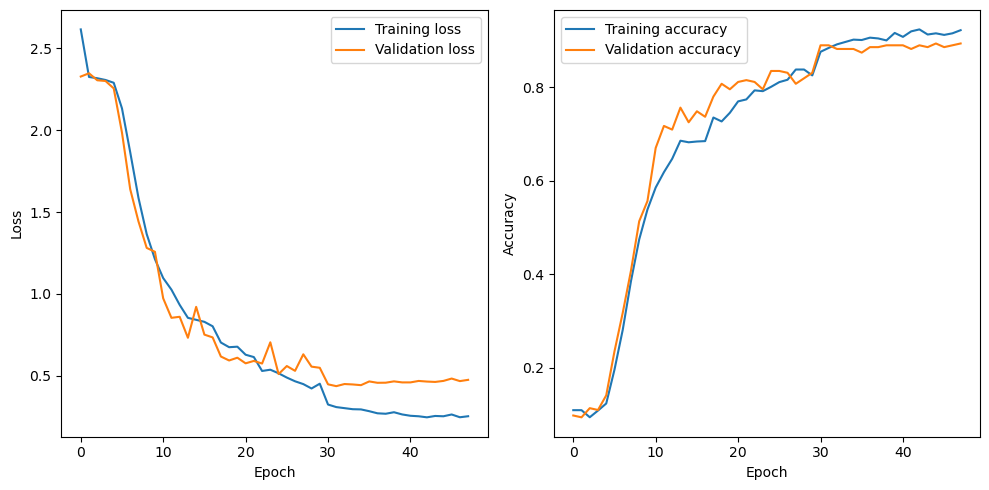

In [34]:
# plot training & validation loss values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history["train_loss"], label="Training loss")
ax[0].plot(history["val_loss"], label="Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
# ax[0].set_yscale('log')
ax[0].legend()

# plot accuracy values
ax[1].plot(history["train_accuracy"], label="Training accuracy")
ax[1].plot(history["val_accuracy"], label="Validation accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

# make it fit better
plt.tight_layout()

# Evaluation


In [ ]:
test_loss, test_acc = validate(model, test_loader, criterion, device)

# torch.save(history["best_weights"], "best_weights.pt")

print(f"\nFinal Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# get the predictions for confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()